# Validate Sites

Run all cells to:
- Import beta values for Lund and Luo cohorts
- Calculate inter-tumor standard deviations in Lund
- Calculate mean intra-tumor standard deviations in Luo
- Plot values in Clock CpGs vs. non-Clock CpGs

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts

import warnings # To suppress some warnings
 
# Suppress the specific FutureWarning
# warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
## Data dictionaries
## Hold certain types of data objects, accessible by cohort name

beta_values = {}      # Holds beta values dataframe for each cohort
clinical = {}         # Holds clinical table for each cohort

# Clock CpGs
Clock_CpGs = np.loadtxt(os.path.join(consts['repo_dir'], '3. Select fCpGs', 'outputs_revision', 'Clock_CpGs.txt'), dtype=str)

# Figure outdir
figure_outdir = 'figures_revision'

In [3]:
## Configure graph
sf = consts['sf']
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

## Lund

### Import data

In [4]:
Lund_clinical_dir = os.path.join(consts['official_indir'], 'Lund')

beta_values['Lund'] = pd.read_table(os.path.join(Lund_clinical_dir, 'GSE75067_betaValues.txt'), index_col=0)
clinical_Lund = pd.read_table(os.path.join(Lund_clinical_dir, 'Lund.clinical.txt'), index_col=0, dtype={'grade':str})
useSamples = clinical_Lund.index[clinical_Lund['in_CpG_dataset']]
beta_values['Lund'] = beta_values['Lund'][useSamples]

### Plot distribution of inter-tumor standard deviations

n = 146
Clock sites median: 0.18759
Non-clock sites median: 0.10201
Wilcoxon rank-sum test: P = 1e-176


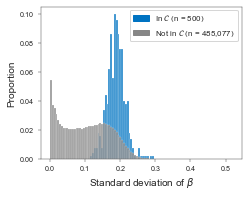

In [5]:
# Calculate inter-tumor standard deviations of beta values
CpG_stdevs = beta_values['Lund'].std(axis=1)

# Dataframe
# Column 1: inter-tumor stdev of that CpG
# Column 2: True iff CpG is in the Clock set
plot_data = pd.DataFrame({'CpG Stdevs':CpG_stdevs, 'Clock Set':CpG_stdevs.index.isin(Clock_CpGs)})

n_Clock = Clock_CpGs.shape[0]
n_not_Clock = CpG_stdevs.shape[0] - n_Clock

# Replace boolean column with a string column (with the following labels)
label_Clock = 'In $\mathcal{C}$' + f' (n = {n_Clock:,})'
label_not_Clock = 'Not in $\mathcal{C}$' + f' (n = {n_not_Clock:,})'
plot_data['Clock Set'] = plot_data['Clock Set'].map({True:label_Clock, False:label_not_Clock})
plot_data = plot_data.rename(columns={'Clock Set':'Type'})

# Colors for plot
color_dict = {label_Clock:consts['palette_jco'][0],
              label_not_Clock:consts['palette_jco'][2]}

# Create plot
fig, ax = plt.subplots(figsize=figsize * sf)
sns.histplot(ax=ax, data=plot_data, x='CpG Stdevs', hue='Type', stat='proportion', common_norm=False, bins=100,
             palette=color_dict, legend=False, alpha=consts['opacity'])

# Customize figure
ax.set_xlabel('Standard deviation of $β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Lund_Validate.pdf'), format='pdf', pad_inches=0.1)

# Calculate medians of both groups and Wilcoxon rank-sums test p-value
print(f'n = {len(useSamples)}')
vals_Clock = plot_data.loc[plot_data['Type'] == label_Clock, 'CpG Stdevs']
vals_not_Clock = plot_data.loc[plot_data['Type'] == label_not_Clock, 'CpG Stdevs']
pvalue = epi_util.wilcoxonRankSums(vals_Clock, vals_not_Clock).pvalue

print(f'Clock sites median: {vals_Clock.median():.5f}')
print(f'Non-clock sites median: {vals_not_Clock.median():.5f}')
print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')


Fig2E_plot_data = plot_data

### Save figure data

In [7]:
Fig2E_df = Fig2E_plot_data.rename({'CpG Stdevs': 'Standard deviation of beta'}, axis=1)
Fig2E_df.reset_index(names='CpG', inplace=True)

epi_util.saveFigureData(Fig2E_df, 'Figure_2E')

## Luo

### Import data

In [8]:
Luo_clinical_dir = os.path.join(consts['official_indir'], 'Luo')

beta_values['Luo'] = pd.read_table(os.path.join(Luo_clinical_dir, 'beta_values.txt'), index_col=0)
sample_map_Luo = pd.read_csv(os.path.join(Luo_clinical_dir, 'sample_map_cleaned.txt'), sep='\t')

In [9]:
# Patients to use data from
using_patients = ['B4', 'B5', 'B6', 'B7', 'B8']

# Sample IDs from those patients
using_GSMs = sample_map_Luo.loc[sample_map_Luo['Patient'].isin(using_patients), 'GSM'].to_list()

# Series: List of Sample IDs for each patient
patient_GSM_lists = sample_map_Luo.groupby('Patient')['GSM'].agg(list)

# Calculate list of intra-tumor stdevs for each CpG
CpG_stdev_list = []
for patient in using_patients:
    beta_values_patient = beta_values['Luo'][patient_GSM_lists.loc[patient]]
    CpG_stdev_list.append(beta_values_patient.std(axis=1).rename(patient))
    
CpG_stdevs = pd.concat(CpG_stdev_list, axis=1)

# Calculate mean of these intra-tumor stdevs -- gives one number per CpG
CpG_stdev_means = CpG_stdevs.mean(axis=1)

Clock sites median: 0.05582
Non-clock sites median: 0.02609
Wilcoxon rank-sum test: P = 6e-108


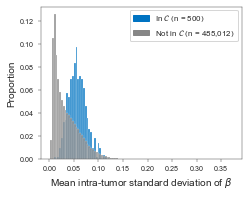

In [10]:
# Dataframe
# Column 1: inter-tumor stdev of that CpG
# Column 2: True iff CpG is in the Clock set
plot_data = pd.DataFrame({'CpG Stdev Means':CpG_stdev_means, 'Clock Set':CpG_stdev_means.index.isin(Clock_CpGs)})

n_Clock = Clock_CpGs.shape[0]
n_not_Clock = CpG_stdev_means.shape[0] - n_Clock

# Replace boolean column with a string column (with the following labels)
label_Clock = 'In $\mathcal{C}$' + f' (n = {n_Clock:,})'
label_not_Clock = 'Not in $\mathcal{C}$' + f' (n = {n_not_Clock:,})'
plot_data['Clock Set'] = plot_data['Clock Set'].map({True:label_Clock, False:label_not_Clock})
plot_data = plot_data.rename(columns={'Clock Set':'Type'})

# Colors for plot
color_dict = {label_Clock:consts['palette_jco'][0],
              label_not_Clock:consts['palette_jco'][2]}

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)
sns.histplot(ax=ax, data=plot_data, x='CpG Stdev Means', hue='Type', stat='proportion', common_norm=False, bins=100, palette=color_dict,
                   legend=False, alpha=consts['opacity'])

# Customize figure
ax.set_xlabel('Mean intra-tumor standard deviation of $β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Create legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Luo_Validate.pdf'), format='pdf', pad_inches=0.1)

# Calculate medians of both groups and Wilcoxon rank-sums test p-value
vals_Clock = plot_data.loc[plot_data['Type'] == label_Clock, 'CpG Stdev Means']
vals_not_Clock = plot_data.loc[plot_data['Type'] == label_not_Clock, 'CpG Stdev Means']
pvalue = epi_util.wilcoxonRankSums(vals_Clock, vals_not_Clock).pvalue

print(f'Clock sites median: {vals_Clock.median():.5f}')
print(f'Non-clock sites median: {vals_not_Clock.median():.5f}')
print(f'Wilcoxon rank-sum test: P = {pvalue:.0e}')


Fig2F_plot_data = plot_data

### Save figure data

In [11]:
Fig2F_df = Fig2F_plot_data.rename({'CpG Stdev Means': 'Mean intra-tumor standard deviation of beta'}, axis=1)
Fig2F_df['Type'] = Fig2F_df['Type'].str.replace('$\\mathcal{C}$', 'C', regex=False)
Fig2F_df.reset_index(names='CpG', inplace=True)

epi_util.saveFigureData(Fig2F_df, 'Figure_2F')